In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import json
import math
import matplotlib.colors as colors
from math import exp,log
from scipy.misc import comb

import re
import functools
import matplotlib.patches as mpatches

import scipy.stats as stats
import misc
import math
import time
import os
import random
import pylab
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

import sys

#local imports
import lazy
from lazy import Data
import misc


Data includes
sig_probs , complete_insertions , sigs_pres , samples , complete_deletions , sub_chromo , ins_extra , del_extra , converter , longest , muts , corr_del , corr_ins , mutation_breakdown , sixes_distribution , triplets_distribution , missense_lnd , silent_lnd , nonsense_lnd , del_frameshift_lnd , del_inframe_lnd , ins_frameshift_lnd , ins_inframe_lnd , lnds , sub_lnds , log_ins_lengths , log_del_lengths , nw_perc_del , nw_perc_ins , nw_perc_del , nw_perc_ins , quads , fingerprints , non_coding_indels , nc_del_rep_nums , nc_ins_rep_nums , A_C_lnd , A_G_lnd , A_T_lnd , C_A_lnd , C_G_lnd , C_T_lnd , G_A_lnd , G_C_lnd , G_T_lnd , T_A_lnd , T_C_lnd , T_G_lnd , 

# Makes the heatmaps for the coding region

To use this notebook notebooks N0 to N3 should be run in order. No additional data is needed.

Key outputs are the logged heatmap values for both insertions and for deletions and these can then be retrieved 

using Data.lg_dist_dels() and Data.lg_dist_ins()

# Looking first at deletions

In [7]:
def make_all_deletions_with_info():
    """use Data.corr_del() to retrieve correct deletion
    positions then groupby the chromosome and identify 
    the nucleotides either side. Count them to identify the
    number of repeats. Order by the number of nucleotides in the 
    indel and the number of repeats"""
    def enrich_deletion_database():
        ddels = Data.corr_del()[['Mutation genome position',
                                 'deletion corrected',
                                 'Mutation ID','del length',
                                 'Gene name']]
        #add in genome position info
        d1 = pd.DataFrame(list(ddels['Mutation genome position']\
                               .map(lambda x: 
                                    x.split('-')[0].split(':') 
                                    if type(x)==str else ['0','0'])))\
                                    .astype(int)

        d1.index = ddels.index
        d1.columns = ['chromo','start']

        d3 = ddels['Mutation genome position'].map(
            lambda x: x.split('-')[1] if type(x)==str else '0').astype(int)
        d3.name = 'stop'

        d2 = pd.concat([ddels,d1,d3],axis = 1)

        lengths = set(ddels['del length'])

        #take out repeats
        ddels1 = ddels.groupby(by = 'Mutation ID').first()
        ddels.dropna(inplace = True)
        ddels['del length']=ddels['del length'].astype(int)
        all_delvalues1 = ddels1['del length'].value_counts()[
            list(range(1,22))]
        all_delvalues = ddels['del length'].value_counts()[
            list(range(1,22))]

        def get_info(row):
            try:
                start = row['start']-1
                stop = row['stop']
                b0 = chromo[max(0,start-100):start]
                a0 = chromo[stop:stop+100]
                del0 = chromo[start:stop]
                if row['Mutation strand'] =='+':
                    return [a0,b0,del0]
                else:
                    return [rev_comp(b0),rev_comp(a0),rev_comp(del0)]
            except TypeError:
                return [np.nan,np.nan,np.nan]

        # for each of the chromosomes add in info about the 
        #nucleotides before and after
        all_dels = []

        for i in range(1, 23):
            one_chromo = d2.loc[d2['chromo']==i]
            chromo = Data.chromos(i)
            deletions = one_chromo.loc[
                one_chromo['Mutation Description'].map(lambda x: 
                                            'deletion' in x.lower())]
            info = pd.DataFrame(list(deletions.apply(get_info,axis = 1)),
                                index = deletions.index, 
                                columns = 
                                ['after','before','deletion'])

            all_dels.append( pd.concat([deletions,info],axis = 1))

        all_dels_df = pd.concat(all_dels)
        all_dels_df['length'] = all_dels_df['deletion'].map(lambda x:len(x) if type(x)==str else 0)

        all_dels_df.to_csv('all_deletions_with_info.csv')
        return ddels1,ddels,all_dels_df

    ddels1,ddels,all_dels_df = enrich_deletion_database()

    """We can now use the information we've generated to see where our indels are.
    We do this by counting how often the deleted motif is repeated before and after the deletion.
    """

    deletions = all_dels_df
    rep = misc.rep_n
    def get_reps(row):

        '''get_reps adds our deletion onto the fasta string 
        before and after 
        and then uses the function misc.rep_n to count 
        how often the motif is repeated.
        '''

        a = row['after']
        b = row['before']
        length = row['length']
        deletion = row['deletion']

        if 'float' in [str(type(i)) for i in [a,b,length,deletion]]:
            return np.nan
        else:
            a0 = deletion + a
            b0 = (b+deletion)[::-1]
            return rep(a0,length)+rep(b0,length)-2

    deletions['reps'] = deletions.apply(get_reps,axis = 1)

    repeats = deletions[['length','reps','Mutation ID','Mutation strand']]
    repeats.index = deletions['reps']

    #We can pull out the information for each of the lengths at the same time by using the pandas groupby function - very useful indeed

    repeats0 = pd.Series(repeats.groupby(by = 'length').groups)
    #lengths down the side, repeats across

    repeats1= repeats0.map(
        lambda x: pd.Series(x).value_counts().\
            loc[range(11)].fillna(0).astype(int)).map(
        lambda x: list(x))

    #lengths down the side, repeats across

    distribution_dels = pd.DataFrame(repeats1.to_dict()).T[:9]
    distribution_dels.to_csv('distribution_dels.csv')

# Comparison with a poisson distribution
My assumption was to begin with that the distribution of indel lengths should be poisson but that turns out 
to very clearly not be the case as seen below.

In [115]:


def compare_with_poisson(lengths):
    d_vc = ddels.loc[ddels['del length']==lengths]['Mutation ID'].value_counts()
    number_of_unique_deletions = d_vc.shape[0]
    number_of_deletions = d_vc.sum()
    #print(number_of_unique_deletions,number_of_deletions)
    mean = number_of_deletions/number_of_unique_deletions
    dvcvc = d_vc.value_counts()
    poisson_prob = lambda i : mean**i* math.exp(-mean)/math.factorial(i)
    expected =np.array( [poisson_prob(i)*dvcvc.sum() for i in range(1,20)])
    actual = dvcvc[list(range(1,20))].as_matrix()
    plt.bar(range(1,20),expected,width=0.8, color = 'blue')
    plt.bar(range(1,20),actual,width=0.8, color = 'green')
    plt.show()
    return actual,expected

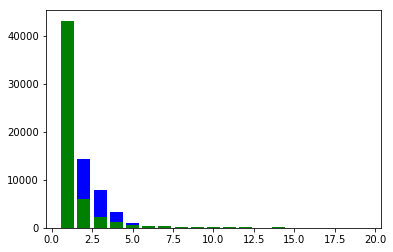

1


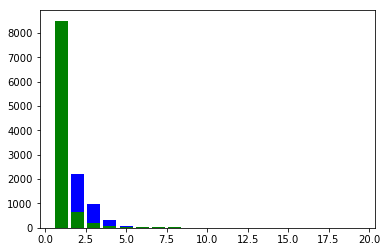

2


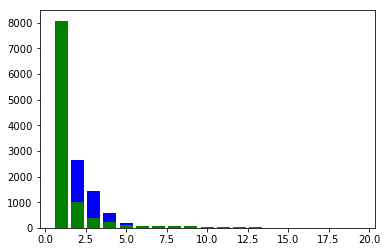

3


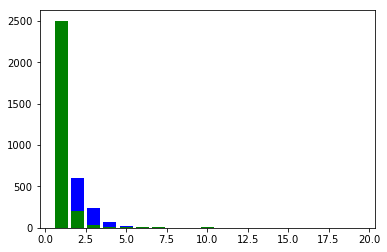

4


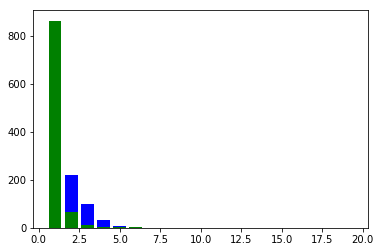

5


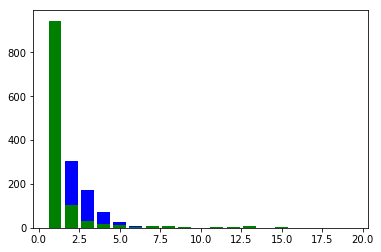

6


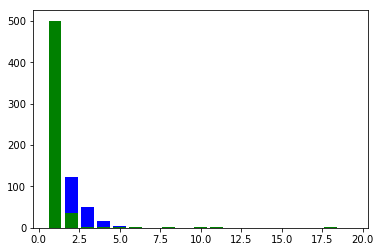

7


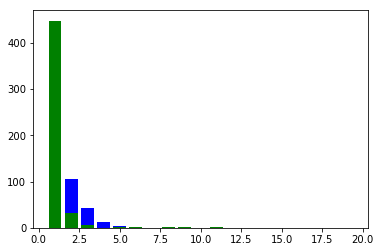

8


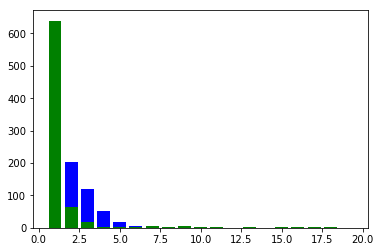

9


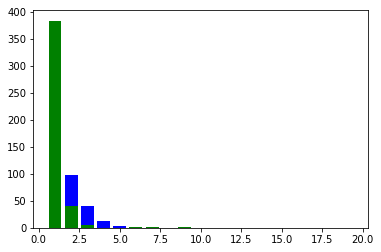

10


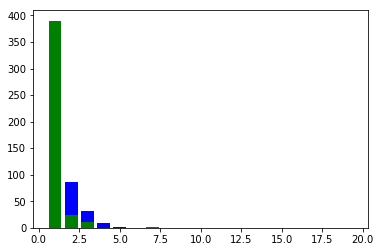

11


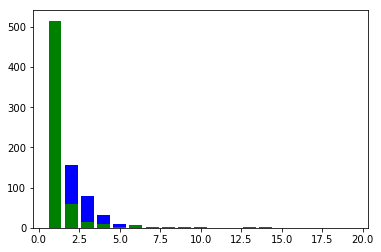

12


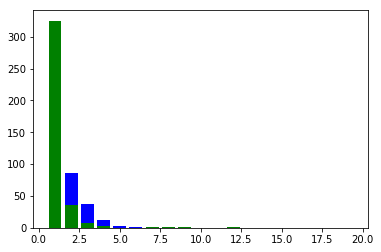

13


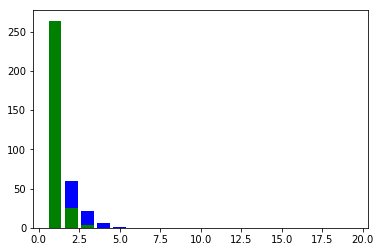

14


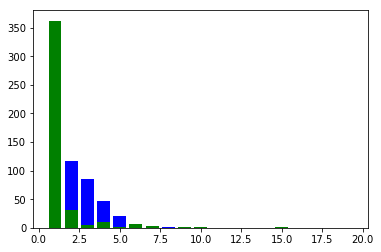

15


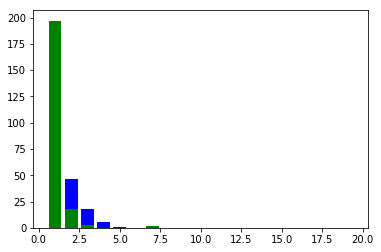

16


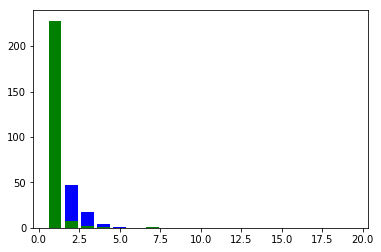

17


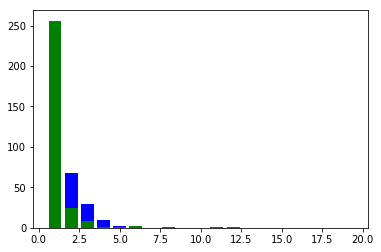

18


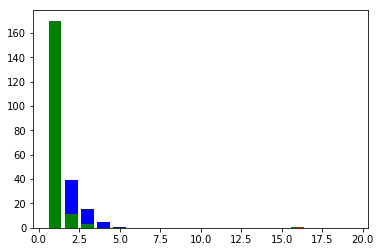

19


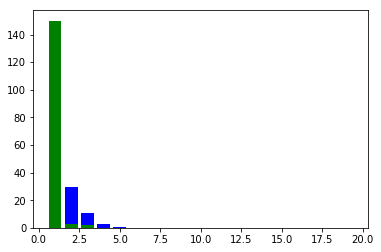

20


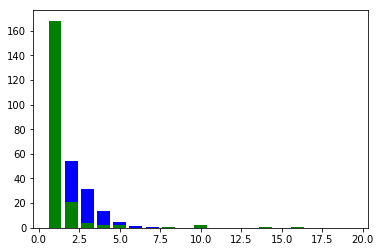

21


In [116]:
cp = {}
for i in range(1,22):
    cp[i]=compare_with_poisson(i)
    print(i)

In [39]:
distribution_dels

0     1     2     3      4      5      6     7     8    9    10
1  8942  7503  4634  6005  12146  14182  14248  8474  3311  823  157
2  5060  2916   951   844    704    377    244    24    52   12   11
3  3815  4115  1564  1455   1823    981    410   477   415  124  139
4  2001   601    62    35      0      0      0     0     0    0    0
5   886   158     9     2      0      0      0     0     0    0    0
6   996   256   154   101     93     51     71     0    12    0    0
7   590    19     0     0      0      0      0     0     0    0    0
8   489     5     0     0      0      0      0     0     0    0    0
9   747   283    70    60      3     24      0     0     0    0    0

In [ ]:
distribution_dels # lengths down the sides and repeats across the top

# Now we do the same with insertions

In [23]:
def make_all_insertions_with_info():
    '''use Data.corr_ins() to retrieve correct insertion
    positions then groupby the chromosome and identify 
    the nucleotides either side. Count them to identify the
    number of repeats. Order by the number of nucleotides in the 
    indel and the number of repeats'''
    
    dins = Data.corr_ins()[['Mutation genome position',
                             'insertion corrected',
                             'Mutation ID','ins length',
                             'Gene name']]
    #add in genome position info
    d1 = pd.DataFrame(list(dins['Mutation genome position']\
                           .map(lambda x: 
                                x.split('-')[0].split(':') 
                                if type(x)==str else ['0','0'])))\
                                .astype(int)

    d1.index = dins.index
    d1.columns = ['chromo','start']

    d3 = dins['Mutation genome position'].map(
        lambda x: x.split('-')[1] if type(x)==str else '0').astype(int)
    d3.name = 'stop'

    d2_ins = pd.concat([dins,d1,d3],axis = 1)


    code = re.compile('c.*ins([A-Z]+)$')
    def get_info_ins(row):
        try:
            c = code.match(row['Mutation CDS'])
            if c!=None:
                insertion = c.group(1)

            else:
                return [np.nan,np.nan,np.nan]
            start = row['start']#note not start-1 cos the insertion happens after start
            b0 = chromo[max(0,start-100):start]
            a0 = chromo[start:start+100]

            if row['Mutation strand'] =='+':
                return [a0,b0,insertion]
            else:
                return [rev_comp(b0),rev_comp(a0),insertion]
        except TypeError:
            return [np.nan,np.nan,np.nan]

    all_ins = []
    for i in range(1,23):

        d21 = d2_ins.loc[d2_ins['chromo']==i]
        chromo = Data.chromos(i)
        d21_extra = d21.apply(get_info_ins,axis =1)
        d21_extra0 = pd.DataFrame(list(d21_extra), index = d21.index, columns = ['after','before','insertion'])
        all_ins.append( pd.concat([d21,d21_extra0], axis = 1))


    all_ins_df = pd.concat(all_ins)


    all_ins_df['length'] = all_ins_df['insertion'].map(lambda x:len(x) if type(x)==str else 0)

    rep = misc.rep_n
    def get_reps_ins(row):

        '''get_reps adds our insertion onto the fasta string before and after 
        and then uses the function misc.rep_n to count how often the motif is repeated.
        '''
        try:
            a = row['after']
            b = row['before']
            length = row['length']
            insertion = row['insertion']

            a0 = insertion + a
            b0 = (b+insertion)[::-1]
            return rep(a0,length)+rep(b0,length)-2

        except TypeError:
            return 0

    all_ins_df['reps'] = all_ins_df.apply(get_reps_ins,axis = 1)


    all_ins1 = all_ins_df.dropna(subset =['after'] )
    #this drops insertions of the form c.1792_1793ins21 which 
    #are too long for us to worry
    #about anyway
    all_ins1.to_csv('insertions_with_info.csv')
    repeats = all_ins1[['length','reps']]
    repeats.index = all_ins1['reps']

    repeats0 = pd.Series(repeats.groupby(by = 'length').groups)
    #lengths down the side and repeats across the top

    repeats1= repeats0.map(
        lambda x: pd.Series(x).value_counts().loc[range(11)].fillna(0).astype(int)).map(lambda x: list(x))

    distribution_ins = pd.DataFrame(repeats1.to_dict()).T[:11][:9]

    distribution_ins.to_csv('distribution_ins.csv')


In [10]:
def log_data(distribution_dels,distribution_ins):
    lg = lambda x: math.log(x) if x>0 else np.nan

    lg_dist_dels = distribution_dels[1:].applymap(lg)
    lg_dist_ins = distribution_ins[1:].applymap(lg)

    lg_dist_dels.to_csv('lg_dist_dels.csv')
    ('lg_dist_dels','auto','')
    lg_dist_ins.to_csv('lg_dist_ins.csv')
    ('lg_dist_ins','auto','')

In [34]:
def show():
    graph_info = [{'cmap': 'Blues',
      'name': 'lg_dist_dels',
      'title': 'a) Log deletion frequency for different \ndel lengths and motif repeats \n',
      'xlabel': 'Deletion Length\n',
      'ylabel': 'Repeats'},
     {'cmap': 'Blues',
      'name': 'lg_dist_ins',
      'title': 'b) Log insertion frequency for different \nins lengths and motif repeats \n',
      'xlabel': 'Insertion Length',
      'ylabel': 'Repeats'},
     {'cmap': 'Purples',
      'name': 'lg_dist_dels-rl',
      'title': 'c) Log ratio of deletion frequency \nto Motif Frequency in the Exome',
      'xlabel': 'Motif Length',
      'ylabel': 'Repeats'},
     {'cmap': 'Purples',
      'name': 'lg_dist_ins-rl',
      'title': 'd) Log ratio of insertion frequency \nto Motif Frequency in the Exome',
      'xlabel': 'Motif Length',
      'ylabel': 'Repeats'},
     {'cmap': 'Reds',
      'name': 'rl',
      'title': 'e) Motif Repeats in the Exome ',
      'xlabel': 'Motif Length',
      'ylabel': 'Repeats'}]

    with open('graph_info_reps.json','w') as f:
        json.dump(graph_info_reps)

    class Info:

        def __init__(self,mydict):

            for k in mydict.keys():
                setattr(self,k,mydict[k])
            setattr(self,'array',sl.Store(self.name,dire = trips).ds().as_matrix())
            self.mx,self.mn = self.sensible_max_min()

        def sensible_max_min(self):
            d = self.array.reshape(90)
            d1=d[np.where(~np.isnan(d))]
            d2=d1[np.where(~np.isinf(d1))]
            return d2.max(),d2.min()

    fig,axarr = plt.subplots(4,2, figsize = (20,35))
    plt.setp(axarr, xticks=range(9), xticklabels=range(1,10))
    plt.setp(axarr, yticks=range(10), yticklabels=range(1,11))

    for i in range(5):

        data = Info(graph_info[i])
        levels = MaxNLocator(nbins=15).tick_values(data.mn,data.mx)
        ax = axarr[i//2,i%2]
        imshow = ax.imshow(data.array,cmap = plt.get_cmap(data.cmap)) 

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="10%", pad=0.5)
        cbar = plt.colorbar(imshow, cax=cax, ticks=MultipleLocator(1))
        ax.set_title(data.title,size = 16)

        ax.set_xlabel(data.xlabel,size = 14)
        ax.set_ylabel(data.ylabel,size=14)

    colours = ['blue','blue','red']*3
    for i in range(6,8):



        ax = axarr[i//2,i%2]
        label = ['f) ','g) '][i-6]
        indel_type = ['deletion','insertion'][i-6]
        array=sl.Store(['log_ratio_del_no_dups','log_ratio_ins_no_dups'][i-6],dire = trips).ds().as_matrix()[0]

        title = '''{}Log ratio of {} to background frequencies
        for {} found after exactly 1 repeat.'''.format(label,indel_type,indel_type)
        xlabel = 'motif length'
        ylabel = 'log ratio'

        scatter = ax.scatter(range(9),array, color = colours)
        ax.set_title(title,size = 16)
        ax.set_xlabel(xlabel,size = 14)
        ax.set_ylabel(ylabel,size=14)

        ax.set_yticks(np.arange(int(array.min()),int(array.max())))
        ax.set_yticklabels(np.arange(int(array.min()),int(array.max())))

    fig.tight_layout()

    plt.show()